# Sea Surface Temperature Time Series Script
 

#### Import the modules

In [3]:
# import the modules you will need for this notebook
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc4
import requests
import os
from subscriber import podaac_data_downloader as pdd
from subscriber import podaac_access as pa
import argparse
import cmocean.cm as cm
import cartopy 
import cartopy.crs as ccrs
import pandas as pd

#### Defines Study Area 

In [4]:
# define the longitude and latitude bounds, central california
min_lon = -121
max_lon = -125.5
min_lat = 32
max_lat = 44

file_list = r"D:\Remote sensing\Project\full_SST"

#### Tests on one file to make sure range is correct for timeseries

lon indices 235 217
lat indices 487 535


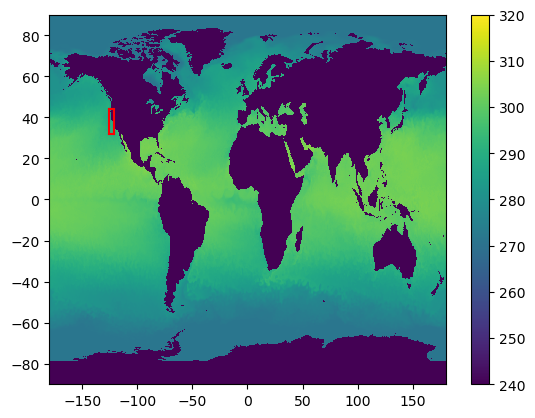

In [5]:
#test on one file 
# define a path to the data folder
data_folder = r"D:\Remote sensing\Project\SST"

# make a file path to one of the nc files
test_file_path = os.path.join(data_folder, "20090720090000-JPL-L4_GHRSST-SSTfnd-MUR25-GLOB-v02.0-fv04.2.nc")

# open the file and read in the ssh variable to a 2D numpy grid
ds = nc4.Dataset(test_file_path)
longitude = np.array(ds.variables["lon"])
latitude = np.array(ds.variables["lat"])
sst = np.array(ds.variables['analysed_sst'][:])
ds.close()

# remove the first timestep
sst = sst[0,:,:]

#sst_masked = np.ma.masked_where(sst > 1000, sst)

# find the indices of the box bounds in the lon and lat grids
min_lon_index = np.argmin(np.abs(longitude-min_lon))
max_lon_index = np.argmin(np.abs(longitude-max_lon))
min_lat_index = np.argmin(np.abs(latitude-min_lat))
max_lat_index = np.argmin(np.abs(latitude-max_lat))

# print the indices to be sure these are ordered correctly
print('lon indices', min_lon_index, max_lon_index)
print('lat indices', min_lat_index, max_lat_index)

#to make sure we are looking were we want to 
def plot_box(ax, min_lon, min_lat, max_lon, max_lat, color="red", linestyle="-"):
    ax.plot([min_lon, min_lon], [min_lat, max_lat], color=color, linestyle=linestyle)
    ax.plot([max_lon, max_lon], [min_lat, max_lat], color=color, linestyle=linestyle)
    ax.plot([min_lon, max_lon], [min_lat, min_lat], color=color, linestyle=linestyle)
    ax.plot([min_lon, max_lon], [max_lat, max_lat], color=color, linestyle=linestyle)

# make a figure
fig = plt.figure()

# make a plot of the SLA
C = plt.pcolormesh(longitude, latitude, sst, vmin=240, vmax=320)
plt.colorbar(C)
# add the coastlines

plot_box(plt.gca(), min_lon, min_lat, max_lon, max_lat)

# format the figure
plt.show()

#### Four Loop to extract dates and SST values within our range

In [7]:
#define your data path and your bounds 
data_folder = r"D:\Remote sensing\Project\full_SST"
min_lon, max_lon = -125.5, -121
min_lat, max_lat = 32, 44

#sorted list of .nc files in the folder
file_list = [f for f in os.listdir(data_folder) if f.endswith(".nc")]
file_list.sort()

#lists to store date and SST data
date_list = []
sst_values = []

#for loop for each file name
for file_name in file_list:
    file_path = os.path.join(data_folder, file_name)
    #the try function trys to do this four loop and if its not successful it will be prompted to stop 
    #or continue depending on function below. I kept running into issues with sampling within the lat and long box
    #so this is how I decided to resolved it, I think it works?
    try:
        #open netcd file
        with nc4.Dataset(file_path, 'r') as ds:
            # Load longitude and latitude arrays
            longitude = np.array(ds.variables['lon'][:])
            latitude = np.array(ds.variables['lat'][:])
            
            #indices for the bounding box
            min_lon_index = np.argmin(np.abs(longitude - min_lon))
            max_lon_index = np.argmin(np.abs(longitude - max_lon))
            min_lat_index = np.argmin(np.abs(latitude - min_lat))
            max_lat_index = np.argmin(np.abs(latitude - max_lat))
            
            #check the indices are within bounds define above
            if (min_lon_index >= len(longitude) or max_lon_index >= len(longitude) or
                min_lat_index >= len(latitude) or max_lat_index >= len(latitude)):
                continue
            
            #extract all the SST and then invalid values
            sst = ds.variables['analysed_sst'][0, :, :]  # Assuming [time, lat, lon] with time = 0
            sst_masked = np.ma.masked_where((sst > 1000) | (sst < -100), sst)
            
            #sampled within the box
            sst_subset = sst_masked[min_lat_index:max_lat_index, min_lon_index:max_lon_index]
            
            #checks and skips subset if its empty
            if sst_subset.count() == 0:
                continue
            
            #appends data to list 
            date_list.append(f"{file_name[:4]}-{file_name[4:6]}-{file_name[6:8]}")
            sst_values.append(sst_subset)
            
    #continue statement here skips an interation that ran into an exception in the four loop above
    except Exception:
        continue

# Convert lists to arrays
date_array = np.array(date_list, dtype="datetime64")
sst_array = np.ma.array(sst_values)

#### Putting a filter for 2019 to matcht the wind data 

In [8]:
#filter
start_year = np.datetime64("2003-01-01")
end_year = np.datetime64("2019-12-31")

#create mask
mask = (date_array >= start_year) & (date_array <= end_year)

#apply mask
filtered_date_array = date_array[mask]
filtered_sst_array = sst_array[mask]

#### Time Series from 2003-2019 of SST in the California Current 

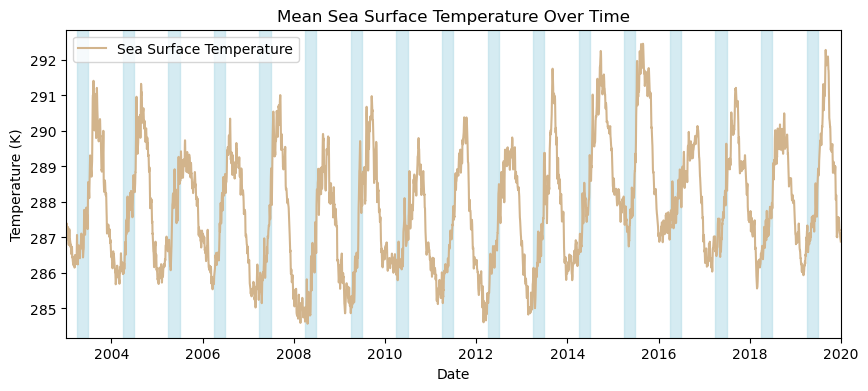

In [9]:
#calculate the mean SST across all spatial points (lat and long)
mean_sst = np.ma.mean(filtered_sst_array, axis=(1, 2))

#temperature plot
fig = plt.figure(figsize=(10, 4))
plt.plot(filtered_date_array, mean_sst, label='Sea Surface Temperature', color='tan')
#write x axis start and end time
plt.xlim(np.datetime64('2003-01-01'), np.datetime64('2020-01-01'))
#dding shaded boxed for april, may, june
for year in range(2003, 2024):
    plt.axvspan(np.datetime64(f'{year}-04-01'), np.datetime64(f'{year}-06-30'), 
                 color='lightblue', alpha=0.5)
    #labels
plt.xlabel('Date')
plt.ylabel('Temperature (K)')
#title
plt.title('Mean Sea Surface Temperature Over Time')
#sjow
plt.legend()
plt.show()

#### Figure #1. Temperature during upwelling season across years

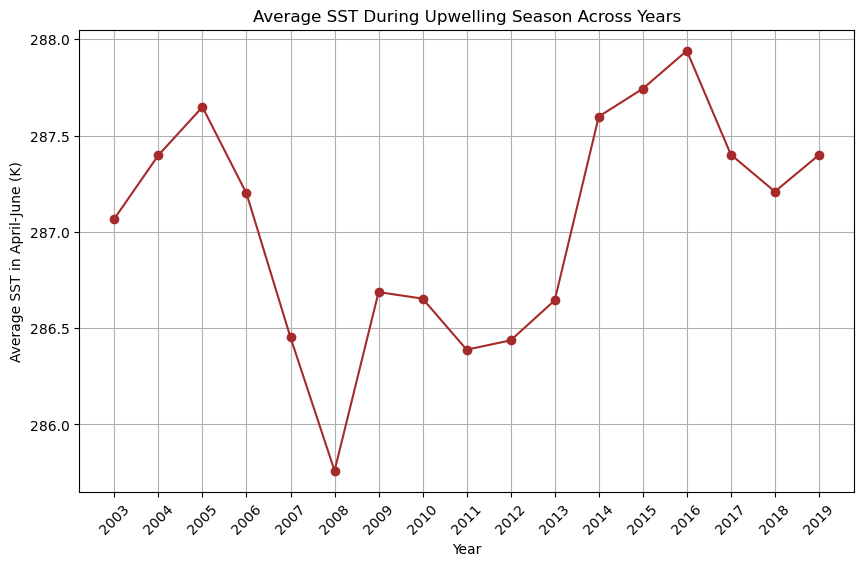

In [10]:
#place for averages
sst_avg_by_year = {}

#loop over dates
for i, date in enumerate(filtered_date_array):
    year = date.astype('datetime64[Y]').astype(int) + 1970 
    month = date.astype('datetime64[M]').astype(int) % 12 + 1  
    
    #apirl, may, and june check
    if month in [4, 5, 6]:
        if 2003 <= year <= 2019:  #limits date
            if year not in sst_avg_by_year:
                sst_avg_by_year[year] = []
            
            #apppend SST to the year
            sst_value = filtered_sst_array[i].compressed() 
            sst_avg_by_year[year].extend(sst_value)  

#calculates averages across months
years = sorted(sst_avg_by_year.keys())
sst_avgs = []

for year in years:
    if sst_avg_by_year[year]: 
        avg_sst = np.mean(sst_avg_by_year[year])
        sst_avgs.append(avg_sst)
    else:
        sst_avgs.append(np.nan)

#graph 
years = list(range(2003, 2020))
plt.figure(figsize=(10, 6))
plt.plot(years, sst_avgs, marker='o', color='brown', linestyle='-')
plt.xlabel('Year')
plt.ylabel('Average SST in April-June (K)')
plt.title('Average SST During Upwelling Season Across Years')
plt.xticks(years, rotation=45)
plt.grid()
plt.show()

Export the CSV for the corrlation test

In [11]:
data = pd.DataFrame({
    "Year": years,
    "SST": sst_avgs
})

# Export to CSV
data.to_csv("SST_yearly_timeseries.csv", index=False, header = False)